In [1]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

In [2]:
# General imports
import os
import tensorflow as tf
from scipy import stats

# Utility imports
from utils.losses import *
from utils.plotting import *
from utils.training import *

np.random.seed(666) # Need to do more to ensure data is the same across runs.

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-08-06 17:33:45.069170: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-06 17:33:45.096532: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-08-06 17:33:45.096693: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-06 17:33:45.098089: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-06 17:33:45.099730: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-06 17:33:45.100017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

# BCE $C$ Parametrizations

In [11]:
# Experiment parameters
num = 2
reps = 100

# Data generation
N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)
lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)
data, m, s = make_data(bkgd, sgnl, N)

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':atan_bce, 'output': 'linear'}

filestr = 'models/univariate/bce_c_param/set_{}/'.format(num)
filestr_1 = filestr + 'linear/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'atan/model_{}.h5'

np.save(filestr + 'm.npy', m)
np.save(filestr + 's.npy', s)

In [6]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 0.6882256865501404 	 14	0.6881949305534363 	 38	0.6881549954414368 	 13	
1 0.6881628632545471 	 12	0.6882348656654358 	 16	0.6881563663482666 	 12	
2 0.6881377100944519 	 11	0.6881455779075623 	 19	0.6881788969039917 	 18	
3 0.6881738901138306 	 17	0.6881164908409119 	 12	0.6881406903266907 	 12	
4 0.688130795955658 	 18	0.6881524920463562 	 14	0.6881380081176758 	 14	
5 0.6881803274154663 	 12	0.6881454586982727 	 11	0.6881465911865234 	 14	
6 0.6881537437438965 	 13	0.6882172226905823 	 16	0.6881501078605652 	 28	
7 0.6882002949714661 	 39	0.6882257461547852 	 12	0.68817138671875 	 13	
8 0.6881285905838013 	 13	0.6881749033927917 	 12	0.6882195472717285 	 21	
9 0.6881157755851746 	 16	0.6881767511367798 	 33	0.6881601214408875 	 14	
10 0.6881738305091858 	 19	0.6881312727928162 	 13	0.6881130337715149 	 12	
11 0.6881515383720398 	 16	0.6881685256958008 	 23	0.6881613731384277 	 11	
12 0.6881522536277771 	 20	0.6881471276283264 	 12	0.688167154788971 	 12	
13 0.6881899833679199 	 21

In [7]:
# Get model likelihood ratios.
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps
for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = atan_lr(model_3, m, s)

In [18]:
# Get average predictions and errors. Add on the labels for plotting.
xs = np.linspace(-6, 6, 1201)

lr_1 = avg_lr(get_preds(lrs_1, xs)) + ('Linear',)
lr_2 = avg_lr(get_preds(lrs_2, xs)) + ('tanh',)
lr_3 = avg_lr(get_preds(lrs_3, xs)) + ('arctan',)

lrr_1 = avg_lrr(lr, get_preds(lrs_1, xs), xs) + ('Linear',)
lrr_2 = avg_lrr(lr, get_preds(lrs_2, xs), xs) + ('tanh',)
lrr_3 = avg_lrr(lr, get_preds(lrs_3, xs), xs) + ('arctan',)

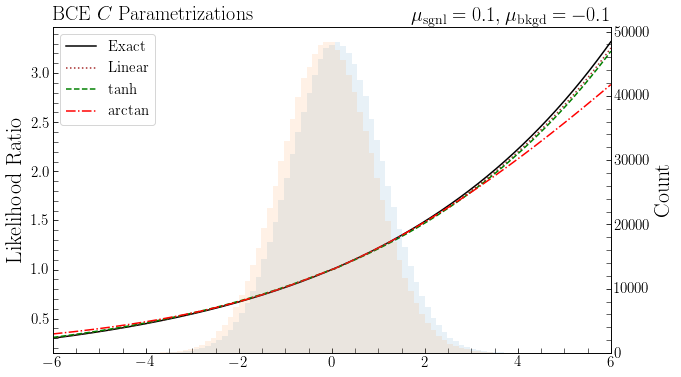

In [22]:
lr_plot([lr_1, lr_2, lr_3],
        lr, 
        bkgd, sgnl,
        xs = np.linspace(-6, 6, 1201),
        title = r'BCE $C$ Parametrizations',
        filename = 'plots/univariate/bce_c_param/set_{}/lrs.png'.format(num))

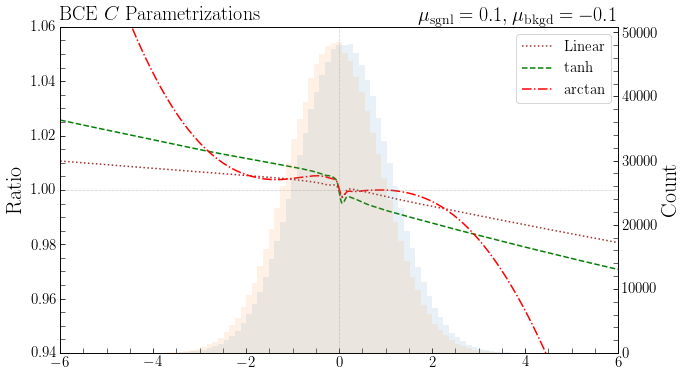

In [23]:
lrr_plot([lrr_1, lrr_2, lrr_3], 
         lr,
         bkgd, sgnl,
         xs = np.linspace(-6, 6, 1201),
         title = r'BCE $C$ Parametrizations',
         filename = 'plots/univariate/bce_c_param/set_{}/lrrs.png'.format(num))

# MSE $C$ Parametrizations

In [28]:
# Experiment parameters
num = 2
reps = 100

# Data generation
N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)
lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)
data, m, s = make_data(bkgd, sgnl, N)

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':atan_mse, 'output': 'linear'}
#params_2 = {'loss':square_mse, 'output':'linear'}
#params_3 = {'loss':exp_mse, 'output':'linear'}

filestr = 'models/univariate/mse_c_param/set_{}/'.format(num)
filestr_1 = filestr + 'linear/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'atan/model_{}.h5'

np.save(filestr + 'm.npy', m)
np.save(filestr + 's.npy', s)

In [29]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 0.24751143157482147 	 13	0.2475416213274002 	 12	0.24751664698123932 	 14	
1 0.24751880764961243 	 14	0.24754780530929565 	 14	0.24751609563827515 	 13	
2 0.24751053750514984 	 12	0.24754315614700317 	 14	0.24751189351081848 	 15	
3 0.24751514196395874 	 14	0.2475205957889557 	 12	0.24751946330070496 	 14	
4 0.2475380301475525 	 11	0.24754905700683594 	 14	0.247537761926651 	 17	
5 0.24756589531898499 	 12	0.24755355715751648 	 12	0.2475413680076599 	 12	
6 0.24754421412944794 	 14	0.2475748509168625 	 11	0.2475252002477646 	 14	
7 0.24752959609031677 	 12	0.2475251853466034 	 12	0.2475312054157257 	 15	
8 0.24753925204277039 	 14	0.24753940105438232 	 12	0.24752093851566315 	 12	
9 0.2475063055753708 	 13	0.24754023551940918 	 12	0.24752342700958252 	 16	
10 0.2475472390651703 	 14	0.24751777946949005 	 12	0.24753136932849884 	 14	
11 0.2475065290927887 	 11	0.24752898514270782 	 13	0.2475152164697647 	 11	
12 0.24753455817699432 	 13	0.24751166999340057 	 14	0.2475191205739975 	 17

In [30]:
# Get model likelihood ratios.
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps
for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = atan_lr(model_3, m, s)

In [31]:
# Get average predictions and errors. Add on the labels for plotting.
xs = np.linspace(-6, 6, 1201)

lr_1 = avg_lr(get_preds(lrs_1, xs)) + ('Linear',)
lr_2 = avg_lr(get_preds(lrs_2, xs)) + ('tanh',)
lr_3 = avg_lr(get_preds(lrs_3, xs)) + ('arctan',)

lrr_1 = avg_lrr(lr, get_preds(lrs_1, xs), xs) + ('Linear',)
lrr_2 = avg_lrr(lr, get_preds(lrs_2, xs), xs) + ('tanh',)
lrr_3 = avg_lrr(lr, get_preds(lrs_3, xs), xs) + ('arctan',)

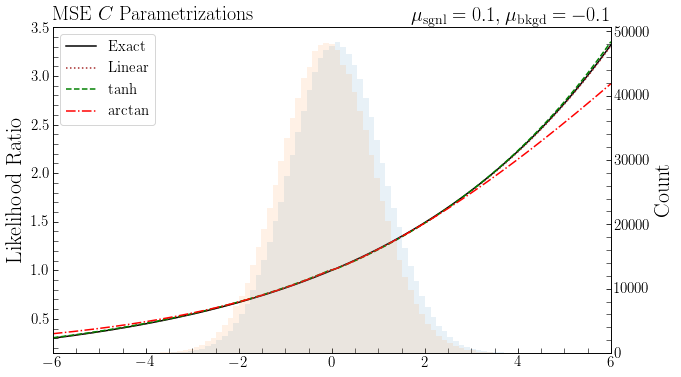

In [32]:
lr_plot([lr_1, lr_2, lr_3], 
        lr,
        bkgd, sgnl,
        xs = xs,
        title = r'MSE $C$ Parametrizations',
        filename='plots/univariate/mse_c_param/set_{}/lrs.png'.format(num))

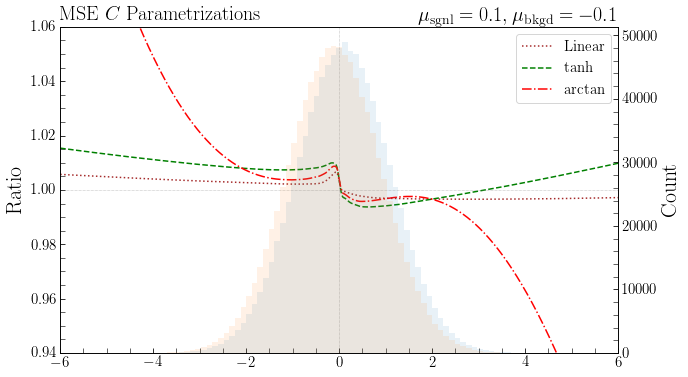

In [33]:
lrr_plot([lrr_1, lrr_2, lrr_3], 
         lr,
         bkgd, sgnl,
         xs = xs,
         title = r'MSE $C$ Parametrizations',
         filename='plots/univariate/mse_c_param/set_{}/lrrs.png'.format(num))

# MSE $A/B$ Parametrization

In [ ]:
num = 0
reps = 20

ps = np.round(np.linspace(-4, 4, 161), 2)
filestr = 'models/mse_ab_param/set_' + str(num) + '/model_{}_{}.h5'

In [ ]:
# Train models
for p in ps:
    print('===================================================\n{}'.format(p))
    params = {'loss': get_mse(p)}
    for i in range(reps):
        print(i, end = ' ')
        model = train(**params)
        print()
        model.save_weights(filestr.format(p, i))

In [ ]:
# Get model likelihood ratios.
lrs = {}
for p in ps:
    print(p)
    lrs[p] = [None] * reps
    params = {'loss': get_mse(p)}
    for i in range(reps):
        model = create_model(**params)
        model.load_weights(filestr.format(p, i))
        lrs[p][i] = pow_odds_lr(model, p) #### FIX THIS
        print(i, end = ' ')
    print()

In [ ]:
mae_avg = []
mae_err = []

for p in ps:
    maes = [mae(lr) for lr in lrs[p]]
    mae_avg += [np.mean(maes)]
    mae_err += [np.std(maes)]
    print(p, '\t', mae_avg[-1])

In [ ]:
mae_avg = np.array(mae_avg)
mae_err = np.array(mae_err)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(ps, mae_avg, c='blue')

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylim(0, 0.5)

plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",
          loc="right",
          fontsize=20);
plt.title(r"MSE $A/B$ Parametrization",loc="left",fontsize=20);
plt.savefig('plots/mse_ab_param/set_{}/maes.png'.format(num), 
            dpi=1200, 
            bbox_inches='tight')

# MLC $C$ Parametrizations

In [4]:
# Experiment parameters
num = 6
reps = 100

# Data generation
N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)
lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)
data, m, s = make_data(bkgd, sgnl, N)

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/mlc_c_param/set_{}/'.format(num)
filestr_1 = filestr + 'linear/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponl/model_{}.h5'

#np.save(filestr + 'm.npy', m)
#np.save(filestr + 's.npy', s)

In [5]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    
    model_2, trace = train(data, **params_2)
    while trace.history['val_loss'][-1] > 0:
        model_2, trace = train(data, **params_2)
    
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 

2022-08-06 17:34:12.886786: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-08-06 17:34:12.894741: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2994530000 Hz
2022-08-06 17:34:12.896029: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e5089e7a70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-06 17:34:12.896065: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-06 17:34:13.023742: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e508a51960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-06 17:34:13.023797: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2022-08-06 17:34:13.025441: I 

-0.010062672197818756 	 39	-0.009660962037742138 	 75	-0.010169451124966145 	 12	
1 -0.010289461351931095 	 71	-0.009821380488574505 	 46	-0.010232146829366684 	 12	
2 -0.010234775021672249 	 40	-0.010145963169634342 	 57	-0.009975611232221127 	 12	
3 -0.010149232111871243 	 38	-0.009835580363869667 	 32	-0.010217131115496159 	 12	
4 -0.010203640908002853 	 57	0.08450943976640701 	 64	-0.009549498558044434 	 35	-0.010308163240551949 	 12	
5 -0.010215927846729755 	 38	-0.010286546312272549 	 100	-0.010278494097292423 	 14	
6 -0.010265751741826534 	 48	-0.009867114014923573 	 35	-0.010175486095249653 	 13	
7 -0.010209293104708195 	 48	-0.010111095383763313 	 47	-0.01023782417178154 	 19	
8 -0.009964841417968273 	 43	-0.009999124333262444 	 38	-0.010177846066653728 	 14	
9 -0.010181151330471039 	 48	-0.009618092328310013 	 37	-0.010068043135106564 	 13	
10 -0.010150562040507793 	 52	0.09790990501642227 	 42	0.08079968392848969 	 26	-0.009671912528574467 	 52	-0.010279888287186623 	 12	
11

In [6]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1)
    lrs_2[i] = square_lr(model_2)
    lrs_3[i] = exp_lr(model_3)

In [7]:
# Calculate predictions
xs = np.linspace(-6, 6, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

In [8]:
lr_1 = avg_lr(preds_1)
lr_2 = avg_lr(preds_2)
lr_3 = avg_lr(preds_3)

lrr_1 = avg_lrr(lr, preds_1, xs)
lrr_2 = avg_lrr(lr, preds_2, xs)
lrr_3 = avg_lrr(lr, preds_3, xs)

In [9]:
h = 10

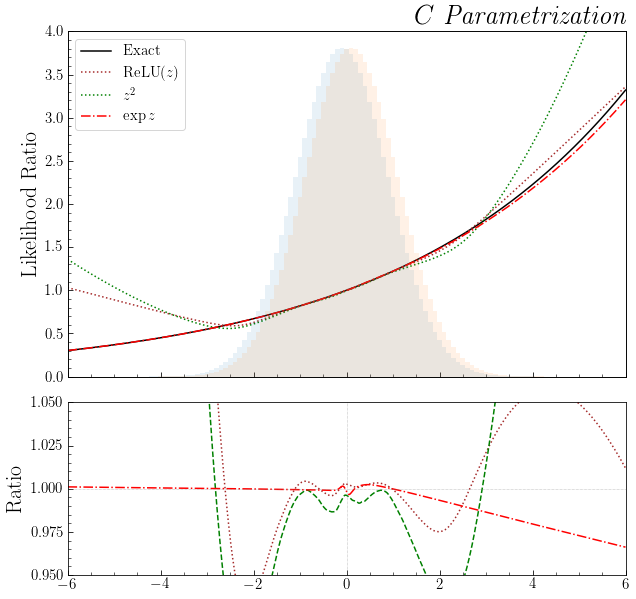

In [10]:
fig, axs = plt.subplots(2, 1,
                        figsize = (h, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

# Plot likelihood ratios
axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, lr_1, c = 'brown', ls = ':', label = r'$\text{ReLU}(z)$')
axs[0].plot(xs, lr_2, c = 'green', ls = ':', label = r'$z^2$')
axs[0].plot(xs, lr_3, c = 'red', ls = '-.', label = r'$\exp{z}$')
axs[0].set_xlim(-6, 6)
axs[0].set_ylim(0, 4)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')
axs[0].set_title(r'\it $C$ Parametrization', loc = 'right')

# Plot exact histograms
hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticks([]);

# Plot likelihood ratio ratios
axs[1].plot(xs, lrr_1, c = 'brown', ls = ':')
axs[1].plot(xs, lrr_2, c = 'green', ls = '--')
axs[1].plot(xs, lrr_3, c = 'red', ls = '-.')
axs[1].axhline(1, ls=":", color="grey", lw=0.5)
axs[1].axvline(0, ls=":", color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)

plt.savefig('plots/paper/mlc_c.png'.format(num), 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

# SQR $C$ Parametrizations

In [43]:
# Experiment parameters
num = 5
reps = 100

# Data generation
N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)
lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)
data, m, s = make_data(bkgd, sgnl, N)

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/sqr_c_param/set_{}/'.format(num)
filestr_1 = filestr + 'linear/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponl/model_{}.h5'

np.save(filestr + 'm.npy', m)
np.save(filestr + 's.npy', s)

In [44]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    
    model_2, trace = train(data, **params_2)
    while (trace.history['val_loss'][-1] > 1.1):
        model_2, trace = train(data, **params_2)
           
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 0.995205283164978 	 100	1.0027775764465332 	 100	0.9951352477073669 	 17	
1 0.9953994750976562 	 100	0.9964641332626343 	 100	0.9951597452163696 	 12	
2 0.9951880574226379 	 65	0.9956147074699402 	 73	0.9950900673866272 	 14	
3 0.995219886302948 	 72	23.717317581176758 	 19	0.995746374130249 	 100	0.9951984882354736 	 14	
4 0.9951714277267456 	 76	0.995482861995697 	 100	0.995174765586853 	 30	
5 0.9951367378234863 	 93	0.9961528778076172 	 100	0.9951390027999878 	 12	
6 0.9953324794769287 	 100	2.2864303588867188 	 48	0.9966872334480286 	 73	0.9951265454292297 	 14	
7 0.9952139258384705 	 90	1.2552282810211182 	 100	1.1712208986282349 	 100	3.3314449787139893 	 23	1.697927713394165 	 100	7.702603816986084 	 27	2.6674070358276367 	 35	20.814285278320312 	 17	1.2243753671646118 	 100	1.2426507472991943 	 100	1.0638858079910278 	 100	0.9951640963554382 	 14	
8 0.9963746666908264 	 79	0.9972648620605469 	 100	0.9950994253158569 	 16	
9 0.997147262096405 	 32	1.2648119926452637 	 100	0.9

# SQR $A$/$B$ Parametrizations

In [ ]:
num = 3
reps = 20

ps = np.round(np.linspace(-2, 2, 81), 2)
sqr_filestr = 'models/sqr_ab_param/set_' + str(num) + '/linear/model_{}_{}.h5'
exp_filestr = 'models/sqr_ab_param/set_' + str(num) + '/exp/model_{}_{}.h5'

In [ ]:
# Train models
for p in ps:
    print('===================================================\n{}'.format(p))
    sqr_params = {'loss': get_sqr(p), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(p), 'output':'linear'}
    for i in range(reps):
        print(i, end = ' ')
        sqr_model = train(**sqr_params)
        exp_model = train(**exp_params)
        print()
        sqr_model.save_weights(sqr_filestr.format(p, i))
        exp_model.save_weights(exp_filestr.format(p, i))

In [ ]:
# Get model likelihood ratios.
sqr_lrs = {}
exp_lrs = {}
for p in ps:
    print(p)
    sqr_lrs[p] = [None] * reps
    exp_lrs[p] = [None] * reps
    sqr_params = {'loss': get_sqr(p), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(p), 'output':'linear'}
    for i in range(reps):
        sqr_model = create_model(**sqr_params)
        exp_model = create_model(**exp_params)
        sqr_model.load_weights(sqr_filestr.format(p, i))
        exp_model.load_weights(exp_filestr.format(p, i))
        sqr_lrs[p][i] = pow_lr(sqr_model, p)
        exp_lrs[p][i] = exp_pow_lr(exp_model, p)
        print(i, end = ' ')
    print()

In [ ]:
sqr_mae_avg = []
sqr_mae_err = []
exp_mae_avg = []
exp_mae_err = []

for p in ps:
    sqr_maes = [mae(lr) for lr in sqr_lrs[p]]
    exp_maes = [mae(lr) for lr in exp_lrs[p]]
    sqr_mae_avg += [np.mean(sqr_maes)]
    sqr_mae_err += [np.std(sqr_maes)]
    exp_mae_avg += [np.mean(exp_maes)]
    exp_mae_err += [np.std(exp_maes)]
    print(p, '\t', sqr_mae_avg[-1], '\t', exp_mae_avg[-1])
    print(p, '\t', sqr_mae_avg[-1])

In [ ]:
sqr_mae_avg = np.array(sqr_mae_avg)
sqr_mae_err = np.array(sqr_mae_err)
exp_mae_avg = np.array(exp_mae_avg)
exp_mae_err = np.array(exp_mae_err)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(ps, sqr_mae_avg, c='blue', label='linear')
plt.plot(ps, exp_mae_avg, c='red', label='exponential')
plt.legend()

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",
          loc="right",
          fontsize=20);
plt.title(r"SQR $A/B$ Parametrization",loc="left",fontsize=20);
plt.savefig('plots/sqr_ab_param/set_{}/maes.png'.format(num), 
            dpi=1200, 
            bbox_inches='tight')

# Loss Comparisons

In [ ]:
num = 3
reps = 100
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':mlc, 'output':'linear'}
sqr_params = {'loss':sqr, 'output':'linear'}

filestr = 'models/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

In [ ]:
for N in Ns:
    print('===================================================\n{}'.format(N))
    # Generate data
    bkgd = stats.norm(-0.1, 1, N)
    sgnl = stats.norm(+0.1, 1, N)
    data, m, s = make_data(bkgd, sgnl, N)
    np.save(filestr + 'm_{}.npy'.format(N), m)
    np.save(filestr + 's_{}.npy'.format(N), s)
    
    for i in range(reps):
        print(i, end = ' ')
        bce_model = train(data, **bce_params)
        mse_model = train(data, **mse_params)
        mlc_model = train(data, **mlc_params)
        sqr_model = train(data, **sqr_params)
        print()
        bce_model.save_weights(bce_filestr.format(N, i))
        mse_model.save_weights(mse_filestr.format(N, i))
        mlc_model.save_weights(mlc_filestr.format(N, i))
        sqr_model.save_weights(sqr_filestr.format(N, i))

## Mean Absolute Error

In [ ]:
# Calculate mean absolute errors
bce_mae_avg = []
mse_mae_avg = []
mlc_mae_avg = []
sqr_mae_avg = []

for N in Ns:
    print(N)
    m = np.load(filestr + 'm_{}.npy'.format(N))
    s = np.load(filestr + 's_{}.npy'.format(N))
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(N, i))
        mse_lrs[i] = odds_lr(mse_model, m, s)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(N, i))
        mlc_lrs[i] = exp_lr(mlc_model, m, s)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(N, i))
        sqr_lrs[i] = exp_lr(sqr_model, m, s)
    
    bce_maes = [mae(lr) for lr in bce_lrs]
    mse_maes = [mae(lr) for lr in mse_lrs]
    mlc_maes = [mae(lr) for lr in mlc_lrs]
    sqr_maes = [mae(lr) for lr in sqr_lrs]
    
    bce_mae_avg += [np.mean(bce_maes)]
    mse_mae_avg += [np.mean(mse_maes)]
    mlc_mae_avg += [np.mean(mlc_maes)]
    sqr_mae_avg += [np.mean(sqr_maes)]

bce_mae_avg = np.array(bce_mae_avg)
mse_mae_avg = np.array(mse_mae_avg)
mlc_mae_avg = np.array(mlc_mae_avg)
sqr_mae_avg = np.array(sqr_mae_avg)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(Ns, bce_mae_avg, c='brown', ls=':', label='BCE')
plt.plot(Ns, mse_mae_avg, c='green', ls='--', label='MSE')
plt.plot(Ns, mlc_mae_avg, c='red', ls='--', label='MLC')
plt.plot(Ns, sqr_mae_avg, c='blue', ls='-.', label='SQR')
#plt.fill_between(Ns, bce_mae_avg - bce_mae_err, bce_mae_avg + bce_mae_err, color='brown', alpha=0.1)
#plt.fill_between(Ns, mse_mae_avg - mse_mae_err, mse_mae_avg + mse_mae_err, color='green', alpha=0.1)
#plt.fill_between(Ns, mlc_mae_avg - mlc_mae_err, mlc_mae_avg + mlc_mae_err, color='red', alpha=0.1)
#plt.fill_between(Ns, sqr_mae_avg - sqr_mae_err, sqr_mae_avg + sqr_mae_err, color='blue', alpha=0.1)
plt.legend()

plt.xscale("log", base=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",
          loc="right",
          fontsize=20);
plt.savefig('plots/loss_comp/set_{}/maes.png'.format(num),
            dpi=1200, 
            bbox_inches='tight')

## Likelihood Ratios

In [ ]:
N = 10**6
reps = 100

In [ ]:
# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(N, i))
    bce_lrs[i] = odds_lr(bce_model)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(N, i))
    mse_lrs[i] = odds_lr(mse_model)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(N, i))
    mlc_lrs[i] = exp_lr(mlc_model)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(N, i))
    sqr_lrs[i] = exp_lr(sqr_model)

In [ ]:
bce_lr = avg_lr(get_preds(bce_lrs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs)) + ('SQR',)

bce_lrr = avg_lrr(get_preds(bce_lrs)) + ('BCE',)
mse_lrr = avg_lrr(get_preds(mse_lrs)) + ('MSE',)
mlc_lrr = avg_lrr(get_preds(mlc_lrs)) + ('MLC',)
sqr_lrr = avg_lrr(get_preds(sqr_lrs)) + ('SQR',)

In [ ]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], 
        filename='plots/loss_comp/set_{}/lrs.png'.format(num))

In [ ]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 
         filename='plots/loss_comp/set_{}/lrrs.png'.format(num))

In [ ]:
bce_mae = np.mean([mae(lr) for lr in bce_lrs])
mse_mae = np.mean([mae(lr) for lr in mse_lrs])
mlc_mae = np.mean([mae(lr) for lr in mlc_lrs])
sqr_mae = np.mean([mae(lr) for lr in sqr_lrs])

In [ ]:
print(bce_mae, mse_mae, mlc_mae, sqr_mae)

# Interpolation Test

In [ ]:
num = 5
N = 10**6
mus = np.round(np.linspace(0.1, 1.5, 15), 2)
sigma = 1

reps = 50

# Model parameters
bce_params = {'loss':bce, 'verbose':0}
mse_params = {'loss':mse, 'verbose':0}
mlc_params = {'loss':exp_mlc, 'output':'linear', 'verbose':0}
sqr_params = {'loss':exp_sqr, 'output':'linear', 'verbose':0}

bce_filestr = 'models/interp/set_' + str(num) + '/bce/model_{}_{}.h5'
mse_filestr = 'models/interp/set_' + str(num) + '/mse/model_{}_{}.h5'
mlc_filestr = 'models/interp/set_' + str(num) + '/mlc/model_{}_{}.h5'
sqr_filestr = 'models/interp/set_' + str(num) + '/sqr/model_{}_{}.h5'

In [ ]:
%%time

for mu in mus:
    print('===================================================\n{}'.format(mu))
    # Generate data
    bkgd = np.random.normal(-mu, sigma, N)
    sgnl = np.random.normal(mu, sigma, N)
    X = np.concatenate([bkgd, sgnl])
    y = np.concatenate([np.zeros(N), np.ones(N)])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    for i in range(reps):
        print(i, end = ' ')
        bce_model = train(**bce_params)
        mse_model = train(**mse_params)
        mlc_model = train(**mlc_params)
        sqr_model = train(**sqr_params)
        print()
        bce_model.save_weights(bce_filestr.format(mu, i))
        mse_model.save_weights(mse_filestr.format(mu, i))
        mlc_model.save_weights(mlc_filestr.format(mu, i))
        sqr_model.save_weights(sqr_filestr.format(mu, i))

## Expected Error

In [ ]:
# Calculate mean absolute errors
bce_mae_avg = []
mse_mae_avg = []
mlc_mae_avg = []
sqr_mae_avg = []

bce_mae_err = []
mse_mae_err = []
mlc_mae_err = []
sqr_mae_err = []

bce_mpe_avg = []
mse_mpe_avg = []
mlc_mpe_avg = []
sqr_mpe_avg = []

bce_mpe_err = []
mse_mpe_err = []
mlc_mpe_err = []
sqr_mpe_err = []

for mu in mus:
    print(mu)
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(mu, i))
        bce_lrs[i] = odds_lr(bce_model)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(mu, i))
        mse_lrs[i] = odds_lr(mse_model)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(mu, i))
        mlc_lrs[i] = exp_lr(mlc_model)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(mu, i))
        sqr_lrs[i] = exp_lr(sqr_model)
    
    mae = make_mae(mu, sigma)
    bce_maes = [mae(lr) for lr in bce_lrs]
    mse_maes = [mae(lr) for lr in mse_lrs]
    mlc_maes = [mae(lr) for lr in mlc_lrs]
    sqr_maes = [mae(lr) for lr in sqr_lrs]
    
    bce_mae_avg += [np.mean(bce_maes)]
    bce_mae_err += [np.std(bce_maes)]
    
    mse_mae_avg += [np.mean(mse_maes)]
    mse_mae_err += [np.std(mse_maes)]
    
    mlc_mae_avg += [np.mean(mlc_maes)]
    mlc_mae_err += [np.std(mlc_maes)]
    
    sqr_mae_avg += [np.mean(sqr_maes)]
    sqr_mae_err += [np.std(sqr_maes)]
    
    print(bce_mae_avg[-1], mse_mae_avg[-1], mlc_mae_avg[-1], sqr_mae_avg[-1])
    
    mpe = make_mpe(mu, sigma)
    bce_mpes = [mpe(lr) for lr in bce_lrs]
    mse_mpes = [mpe(lr) for lr in mse_lrs]
    mlc_mpes = [mpe(lr) for lr in mlc_lrs]
    sqr_mpes = [mpe(lr) for lr in sqr_lrs]
    
    bce_mpe_avg += [np.mean(bce_mpes)]
    bce_mpe_err += [np.std(bce_mpes)]
    
    mse_mpe_avg += [np.mean(mse_mpes)]
    mse_mpe_err += [np.std(mse_mpes)]
    
    mlc_mpe_avg += [np.mean(mlc_mpes)]
    mlc_mpe_err += [np.std(mlc_mpes)]
    
    sqr_mpe_avg += [np.mean(sqr_mpes)]
    sqr_mpe_err += [np.std(sqr_mpes)]
    
    print(bce_mpe_avg[-1], mse_mpe_avg[-1], mlc_mpe_avg[-1], sqr_mpe_avg[-1])

bce_mae_avg = np.array(bce_mae_avg)
mse_mae_avg = np.array(mse_mae_avg)
mlc_mae_avg = np.array(mlc_mae_avg)
sqr_mae_avg = np.array(sqr_mae_avg)

bce_mae_err = np.array(bce_mae_err)
mse_mae_err = np.array(mse_mae_err)
mlc_mae_err = np.array(mlc_mae_err)
sqr_mae_err = np.array(sqr_mae_err)

bce_mpe_avg = np.array(bce_mpe_avg)
mse_mpe_avg = np.array(mse_mpe_avg)
mlc_mpe_avg = np.array(mlc_mpe_avg)
sqr_mpe_avg = np.array(sqr_mpe_avg)

bce_mpe_err = np.array(bce_mpe_err)
mse_mpe_err = np.array(mse_mpe_err)
mlc_mpe_err = np.array(mlc_mpe_err)
sqr_mpe_err = np.array(sqr_mpe_err)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(mus, bce_mae_avg, c='brown', ls=':', label='BCE')
plt.plot(mus, mse_mae_avg, c='green', ls='--', label='MSE')
plt.plot(mus, mlc_mae_avg, c='red', ls='--', label='MLC')
plt.plot(mus, sqr_mae_avg, c='blue', ls='-.', label='SQR')
plt.legend()

plt.yscale("log", basey=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$\mu$')

plt.savefig('plots/interp/set_{}/maes.png'.format(num),
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(mus, bce_mpe_avg, c='brown', ls=':', label='BCE')
plt.plot(mus, mse_mpe_avg, c='green', ls='--', label='MSE')
plt.plot(mus, mlc_mpe_avg, c='red', ls='--', label='MLC')
plt.plot(mus, sqr_mpe_avg, c='blue', ls='-.', label='SQR')
plt.legend()
#plt.ylim(0, 5)

#plt.xscale("log", base=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Percent Error (\%)')
plt.xlabel(r'$\mu$')

plt.savefig('plots/interp/set_{}/mpes.png'.format(num),
            dpi=1200, 
            bbox_inches='tight')

## Single Test

In [ ]:
xs = np.linspace(-4, 4, 1000)
bce_lr = avg_lr(get_preds(bce_lrs, xs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs, xs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs, xs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs, xs)) + ('SQR',)

bce_lrr = avg_lrr(get_preds(bce_lrs, xs), xs) + ('BCE',)
mse_lrr = avg_lrr(get_preds(mse_lrs, xs), xs) + ('MSE',)
mlc_lrr = avg_lrr(get_preds(mlc_lrs, xs), xs) + ('MLC',)
sqr_lrr = avg_lrr(get_preds(sqr_lrs, xs), xs) + ('SQR',)

In [ ]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], 
        xs=xs,
        filename='plots/interp/set_{}/lrs.png'.format(num))

In [ ]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 
         xs=xs,
         filename='plots/interp/set_{}/lrrs.png'.format(num))

# Betas

In [ ]:
num = 0
reps = 100

bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)
N = 10**6

data = make_data(bkgd, sgnl, N) + [N]

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}

bce_filestr = 'models/betas/set_' + str(num) + '/bce/model_{}.h5'
mse_filestr = 'models/betas/set_' + str(num) + '/mse/model_{}.h5'
mlc_filestr = 'models/betas/set_' + str(num) + '/mlc/model_{}.h5'
sqr_filestr = 'models/betas/set_' + str(num) + '/sqr/model_{}.h5'

In [ ]:
%%time
# Train and save models

for i in range(reps):
    print(i, end = ' ')
    bce_model = train(data, **bce_params)
    mse_model = train(data, **mse_params)
    mlc_model = train(data, **mlc_params)
    sqr_model = train(data, **sqr_params)
    print()
    bce_model.save_weights(bce_filestr.format(i))
    mse_model.save_weights(mse_filestr.format(i))
    mlc_model.save_weights(mlc_filestr.format(i))
    sqr_model.save_weights(sqr_filestr.format(i))

# Gamma

In [ ]:
num = 0
reps = 100

bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)
N = 10**6

data = make_data(bkgd, sgnl, N) + [N]

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}

bce_filestr = 'models/gammas/set_' + str(num) + '/bce/model_{}.h5'
mse_filestr = 'models/gammas/set_' + str(num) + '/mse/model_{}.h5'
mlc_filestr = 'models/gammas/set_' + str(num) + '/mlc/model_{}.h5'
sqr_filestr = 'models/gammas/set_' + str(num) + '/sqr/model_{}.h5'

In [ ]:
%%time
# Train and save models

for i in range(reps):
    print(i, end = ' ')
    bce_model = train(data, **bce_params)
    mse_model = train(data, **mse_params)
    mlc_model = train(data, **mlc_params)
    sqr_model = train(data, **sqr_params)
    print()
    bce_model.save_weights(bce_filestr.format(i))
    mse_model.save_weights(mse_filestr.format(i))
    mlc_model.save_weights(mlc_filestr.format(i))
    sqr_model.save_weights(sqr_filestr.format(i))

# 2D Gaussians

In [ ]:
num = 0
reps = 100
Ns = 10**np.arange(2, 8)

mu = np.array([0.1, 0])
sg = np.eye(2)

bkgd = stats.multivariate_normal(-mu, sg)
sgnl = stats.multivariate_normal(mu, sg)

# Model parameters
bce_params = {'loss':bce, 'd': 2, 'verbose': 0}
mse_params = {'loss':mse, 'd': 2, 'verbose': 0}
mlc_params = {'loss':mlc, 'd': 2, 'output':'linear', 'verbose': 0}
sqr_params = {'loss':sqr, 'd': 2, 'output':'linear', 'verbose': 0}

bce_filestr = 'models/multi/scratch/set_' + str(num) + '/bce/model_{}_{}.h5'
mse_filestr = 'models/multi/scratch/set_' + str(num) + '/mse/model_{}_{}.h5'
mlc_filestr = 'models/multi/scratch/set_' + str(num) + '/mlc/model_{}_{}.h5'
sqr_filestr = 'models/multi/scratch/set_' + str(num) + '/sqr/model_{}_{}.h5'

In [ ]:
for N in Ns:
    print('===================================================\n{}'.format(N))
    # Generate data
    data = make_data(bkgd, sgnl, N) + [N]
    
    for i in range(reps):
        print(i)
        bce_model, trace = train(data, **bce_params)
        print()
        mse_model, trace = train(data, **mse_params)
        print()
        mlc_model, trace = train(data, **mlc_params)
        while np.isnan(trace.history['val_loss'][-1]):
            mlc_model, trace = train(data, **mlc_params)
        print()
        sqr_model, trace = train(data, **sqr_params)
        while np.isnan(trace.history['val_loss'][-1]):
            sqr_model, trace = train(data, **sqr_params)
        print('\n\n')
        bce_model.save_weights(bce_filestr.format(N, i))
        mse_model.save_weights(mse_filestr.format(N, i))
        mlc_model.save_weights(mlc_filestr.format(N, i))
        sqr_model.save_weights(sqr_filestr.format(N, i))

In [ ]:
lr = make_lr(bkgd, sgnl)

In [ ]:
g = np.meshgrid(np.linspace(-6, 6, 300), np.linspace(-6, 6, 300))
g = np.append(g[0].reshape(-1,1),g[1].reshape(-1,1),axis = 1)

In [ ]:
bce_model = create_model(**bce_params)
bce_model.load_weights(bce_filestr.format(0))
bce_lr = odds_lr(bce_model)

In [ ]:
mse_model = create_model(**mse_params)
mse_model.load_weights(mse_filestr.format(0))
mse_lr = odds_lr(mse_model)

In [ ]:
mlc_model = create_model(**mlc_params)
mlc_model.load_weights(mlc_filestr.format(0))
mlc_lr = pure_lr(mlc_model)

In [ ]:
sqr_model = create_model(**sqr_params)
sqr_model.load_weights(sqr_filestr.format(0))
sqr_lr = pure_lr(sqr_model)

In [ ]:
mae = make_mae(bkgd, sgnl)

In [ ]:
mae(bce_lr)

In [ ]:
mae(mse_lr)

In [ ]:
mae(mlc_lr)

In [ ]:
mae(sqr_lr)

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(g[:, 0], g[:, 1], lr(g), s = 5, c = lr(g), cmap = 'plasma')
ax.scatter(g[:, 0], g[:, 1], bce_lr(g), s = 5, c = bce_lr(g), cmap = 'viridis')
#ax.scatter(g[:, 0], g[:, 1], mse_lr(g), s = 5, c = mse_lr(g), cmap = 'cividis')

# MLC $C$ Parametrization

In [ ]:
num = 0
reps = 100

mu = np.array([0.1, 0])
sg = np.eye(2)
bkgd = stats.multivariate_normal(-mu, sg)
sgnl = stats.multivariate_normal(+mu, sg)
N = 10**6

data = make_data(bkgd, sgnl, N) + [N]

# Model parameters
params_1 = {'loss':mlc, 'd': 2, 'output':'relu'}
params_2 = {'loss':square_mlc, 'd': 2,  'output':'linear'}
params_3 = {'loss':exp_mlc, 'd': 2, 'output':'linear'}

filestr_1 = 'models/multi/mlc_c_param/set_' + str(num) + '/linear/model_{}.h5'
filestr_2 = 'models/multi/mlc_c_param/set_' + str(num) + '/square/model_{}.h5'
filestr_3 = 'models/multi/mlc_c_param/set_' + str(num) + '/exp/model_{}.h5'

In [ ]:
%%time

for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

# SQR $C$ Parametrization

In [ ]:
num = 0
reps = 100

mu = np.array([0.1, 0])
sg = np.eye(2)
bkgd = stats.multivariate_normal(-mu, sg)
sgnl = stats.multivariate_normal(+mu, sg)
N = 10**6

data = make_data(bkgd, sgnl, N) + [N]

# Model parameters
params_1 = {'loss':sqr, 'd': 2, 'output':'relu'}
params_2 = {'loss':square_sqr, 'd': 2,  'output':'linear'}
params_3 = {'loss':exp_sqr, 'd': 2, 'output':'linear'}

filestr_1 = 'models/multi/sqr_c_param/set_' + str(num) + '/linear/model_{}.h5'
filestr_2 = 'models/multi/sqr_c_param/set_' + str(num) + '/square/model_{}.h5'
filestr_3 = 'models/multi/sqr_c_param/set_' + str(num) + '/exp/model_{}.h5'

In [ ]:
%%time

for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

# Scratch

## 1. Loss Comparison for Gamma Data

In [ ]:
### Generate the data.
N = 10**6
r = 5
lam = 1

# Background is Gamma(r, λ). Signal is Gamma(r + 1, λ)
bkgd = np.random.gamma(r, lam, N)
sgnl = np.random.gamma(r + 1, lam, N)
D = np.concatenate([bkgd, sgnl])
X = (D - np.mean(D)) / np.std(D)
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
def lr(x):
    #return np.exp(-10 + 11) * (10/11)**x
    #return np.exp(-(1/(2 * sigma**2)) * ( (x - mu)**2 - (x + mu)**2))
    r_1 = r
    r_2 = r + 1
    v_1 = lam
    v_2 = lam
    return v_2**r_2 * np.math.factorial(r_1 - 1) * x**(r_2 - r_1) * \
           np.exp(-(v_2 - v_1)*x) / (v_1**r_1 * np.math.factorial(r_2 - 1))

In [ ]:
num = 4
reps = 20

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}

bce_filestr = 'models/scratch/set_' + str(num) + '/bce/model_{}.h5'
mse_filestr = 'models/scratch/set_' + str(num) + '/mse/model_{}.h5'
mlc_filestr = 'models/scratch/set_' + str(num) + '/mlc/model_{}.h5'
sqr_filestr = 'models/scratch/set_' + str(num) + '/sqr/model_{}.h5'

In [ ]:
%%time

for i in range(reps):
    print(i, end = ' ')
    bce_model = train(**bce_params)
    mse_model = train(**mse_params)
    mlc_model = train(**mlc_params)
    sqr_model = train(**sqr_params)
    print()
    bce_model.save_weights(bce_filestr.format(i))
    mse_model.save_weights(mse_filestr.format(i))
    mlc_model.save_weights(mlc_filestr.format(i))
    sqr_model.save_weights(sqr_filestr.format(i))

In [ ]:
# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(i))
    bce_lrs[i] = odds_lr(bce_model)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(i))
    mse_lrs[i] = odds_lr(mse_model)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(i))
    mlc_lrs[i] = exp_lr(mlc_model)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(i))
    sqr_lrs[i] = exp_lr(sqr_model)

In [ ]:
ds = np.linspace(0, 20, 1000)
xs = (ds - np.mean(D)) / np.std(D)

bce_lr = avg_lr(get_preds(bce_lrs, xs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs, xs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs, xs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs, xs)) + ('SQR',)

bce_lrr = avg_lrr(get_preds(bce_lrs, xs), ds) + ('BCE',)
mse_lrr = avg_lrr(get_preds(mse_lrs, xs), ds) + ('MSE',)
mlc_lrr = avg_lrr(get_preds(mlc_lrs, xs), ds) + ('MLC',)
sqr_lrr = avg_lrr(get_preds(sqr_lrs, xs), ds) + ('SQR',)

In [ ]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], 
        filename='plots/scratch/set_{}/lrs.png'.format(num))

In [ ]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 
         filename='plots/scratch/set_{}/lrrs.png'.format(num))

## 2. Test on Non-Zero-Centered Gaussians

In [ ]:
N = 10**6
mu = 10
d = 0.1
sigma = 1

# Background is Normal(μ - d, σ). Signal is Normal(μ + d, σ))
bkgd = np.random.normal(mu - d, sigma, N)
sgnl = np.random.normal(mu + d, sigma, N)
D = np.concatenate([bkgd, sgnl])
X = (D - np.mean(D)) / np.std(D)
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
def lr(x):
    return np.exp(-(1/(2 * sigma**2)) * ( (x - 10.1)**2 - (x - 9.9)**2))

In [ ]:
num = 3
reps = 20

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}

bce_filestr = 'models/scratch/set_' + str(num) + '/bce/model_{}.h5'
mse_filestr = 'models/scratch/set_' + str(num) + '/mse/model_{}.h5'
mlc_filestr = 'models/scratch/set_' + str(num) + '/mlc/model_{}.h5'
sqr_filestr = 'models/scratch/set_' + str(num) + '/sqr/model_{}.h5'

In [ ]:
%%time

for i in range(reps):
    print(i, end = ' ')
    bce_model = train(**bce_params)
    mse_model = train(**mse_params)
    mlc_model = train(**mlc_params)
    sqr_model = train(**sqr_params)
    print()
    bce_model.save_weights(bce_filestr.format(i))
    mse_model.save_weights(mse_filestr.format(i))
    mlc_model.save_weights(mlc_filestr.format(i))
    sqr_model.save_weights(sqr_filestr.format(i))

In [ ]:
# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(i))
    bce_lrs[i] = odds_lr(bce_model)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(i))
    mse_lrs[i] = odds_lr(mse_model)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(i))
    mlc_lrs[i] = exp_lr(mlc_model)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(i))
    sqr_lrs[i] = exp_lr(sqr_model)

In [ ]:
ds = np.linspace(4, 16, 1000)
xs = (ds - np.mean(D)) / np.std(D)

bce_lr = avg_lr(get_preds(bce_lrs, xs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs, xs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs, xs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs, xs)) + ('SQR',)

bce_lrr = avg_lrr(get_preds(bce_lrs, xs), ds) + ('BCE',)
mse_lrr = avg_lrr(get_preds(mse_lrs, xs), ds) + ('MSE',)
mlc_lrr = avg_lrr(get_preds(mlc_lrs, xs), ds) + ('MLC',)
sqr_lrr = avg_lrr(get_preds(sqr_lrs, xs), ds) + ('SQR',)

In [ ]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], 
        filename='plots/scratch/set_{}/lrs.png'.format(num))

In [ ]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 
         filename='plots/scratch/set_{}/lrrs.png'.format(num))